# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import yfinance as yf
import arch
import riskfolio as rp

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [41]:
tic=pd.read_excel('TIC.xlsx')

In [42]:
tic

,Nomi,Pesi,Ticker
0,MSCI USA,0.20,CSUS.MI
1,Global Convertible Bond,0.05,GCVE.MI
2,Ultrashort Bond,0.10,ERN1.L
3,Inflation Linked Govt Bond,0.05,IBCI.MI
4,Gold,0.15,GOLD.SG
5,MSCI AC World ESG,0.25,XMAW.MI
6,US TREASURY,0.05,VUTY.AS
7,COMMODITIES,0.05,CRB.PA
8,Eurozone GVT Aggregate,0.10,SYBB.F


In [131]:
tic.iloc[:,:2].set_index(tic['Nomi']).drop('Nomi')

KeyError: "['Nomi'] not found in axis"

In [127]:
tic.iloc[:,:2].set_index.plot.pie()

ValueError: pie requires either y column or 'subplots=True'

In [43]:
tickers=list(tic['Ticker'])
tickers.sort()

In [44]:
tickers

['CRB.PA',
 'CSUS.MI',
 'ERN1.L',
 'GCVE.MI',
 'GOLD.SG',
 'IBCI.MI',
 'SYBB.F',
 'VUTY.AS',
 'XMAW.MI']

In [45]:
data=yf.download(tickers,interval='1d')[['Adj Close']]

[*********************100%***********************]  9 of 9 completed


In [46]:
data.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

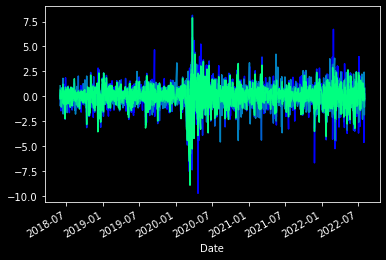

In [47]:
plt.style.use('dark_background')

rets=((np.log(data) - np.log(data.shift(1))).dropna()*100)

rets.plot(legend=False,cmap='winter')

<AxesSubplot:xlabel='Date'>

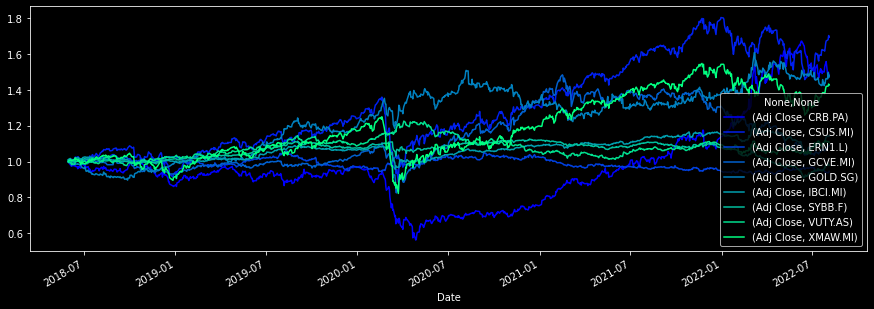

In [48]:
(rets/100+1).cumprod().plot(figsize=(15,5),cmap='winter')

# Sample mean

Assumiamo che la sample mean sia informativa

In [49]:
rets.columns=tickers
model={}
result={}
for i in tickers:
    model[i]=arch.univariate.ConstantMean(rets.loc[:,i])
    result[i]=model[i].fit(disp="off")

# Monte Carlo

Assumiamo che i rendimenti seguano una distribuzione multivariata con t di student (con 8 gradi di libertà)

i.e. $R_t \sim MVT(\mu, \Sigma)$

Usiamo la fattorizzazione di Cholesky per trovare la matrice triangolare inferiore $L$ tale che $LL'=\Sigma$

Quindi i rendimenti degli asset possono essere descritti come:

$R_T=\mu + L Z_t$

Dove $Z_t\sim  student \ t_{n=8}$

In [93]:
n_t=252
n_mc=5000

In [94]:
weights=np.array(tic.iloc[:,1])

## Sample mean

In [95]:
mu={}
for i in tickers:
    mu[i]=result[i].params['mu']/100
mu_df=pd.DataFrame.from_dict(mu,orient='index')

## Var/Cov Matrix con denoising and detoning

In [96]:
cov=rp.ParamsEstimation.covar_matrix(rets/100,method='fixed')

In [97]:
from datetime import datetime, timedelta


## Loop

In [98]:
portf_returns = np.full((n_t,n_mc),0.)

for i in range(0,n_mc):
    Z = np.random.standard_t(8,size=len(tickers)*n_t)
    Z = Z.reshape((len(tickers),n_t))
    L = np.linalg.cholesky(cov)
    wkrets=np.inner(L,np.transpose(Z))+np.array(mu_df)
    portf_r = np.cumprod(np.inner(weights,np.transpose(wkrets)) + 1)
    future_dates = [rets.index[-1] + timedelta(weeks=x) for x in range(0,n_t+1)]
    portf_returns[:,i] = portf_r

## Funzioni

In [99]:
def band(r,n_t=n_t):
    y2=r
    y1=1
    lt2=np.log(n_t)
    b=(y2-y1)/lt2
    a=y1

    U= np.zeros([n_t + 1, 1])
    for t in range(0, int(n_t)+1):
      U[t] = a+b*np.log(t+1)
    U_df=pd.DataFrame(U,index=future_dates)
    return U_df

In [100]:
def trend(r,n_t=n_t):
    L= np.zeros([n_t + 1, 1])
    L[0]=1
    for t in range(1, int(n_t)+1):
      L[t] = L[t-1]*(r**(1/n_t))
    L_df=pd.DataFrame(L,index=future_dates)
    return L_df

## Grafico

In [101]:
ptf_returns=np.insert(portf_returns, 0, 1, axis=0)

In [102]:
hist=((rets@weights)/100+1).cumprod()

[]

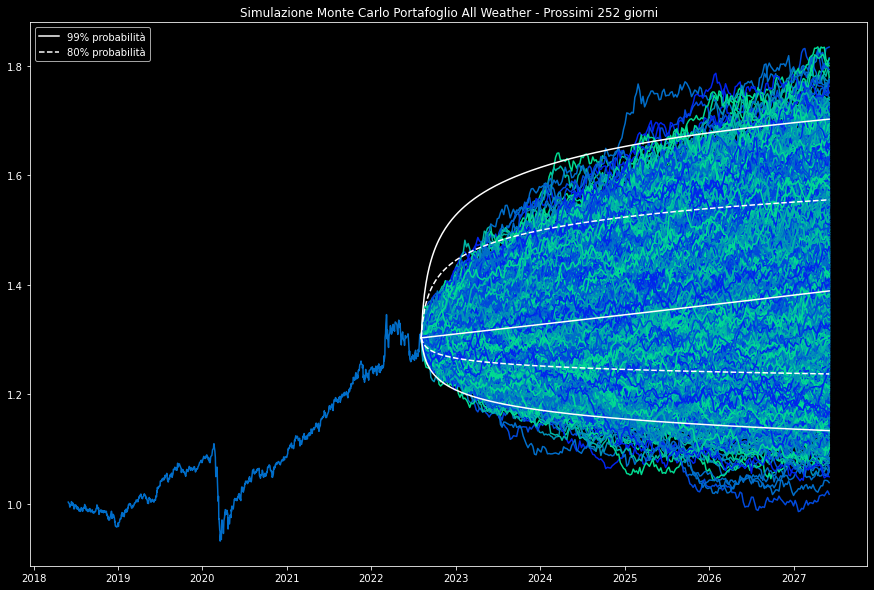

In [103]:

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

with sns.color_palette("winter"):
    plt.plot(hist[-1]*pd.DataFrame(ptf_returns,index=future_dates))

    
plt.plot(hist)
    
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.99)),color='white', label='99% probabilità')
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.01)),color='white',)
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.9)),color='white', label='80% probabilità',linestyle='dashed')
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.1)),color='white', linestyle='dashed')



plt.plot(hist[-1]*trend(np.quantile(portf_returns[-1],q=0.5)),color='white')
plt.title('Simulazione Monte Carlo Portafoglio All Weather - Prossimi 252 giorni')
plt.legend()
plt.plot()

In [72]:
print('Nel 99% dei casi non dovresti perdere più del: ' +str((np.quantile(portf_returns[-1],q=0.01)-1)*100))
print('Nel 99% dei casi non dovresti guadagnare più del: ' +str((np.quantile(portf_returns[-1],q=0.99)-1)*100))

Nel 99% dei casi non dovresti perdere più del: -7.35357394734012
Nel 99% dei casi non dovresti guadagnare più del: 11.081951199023932


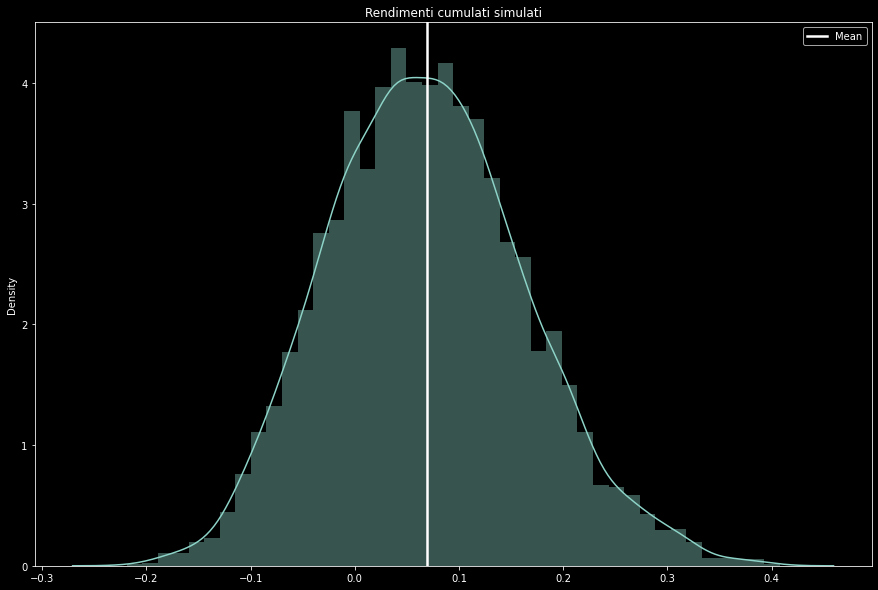

In [120]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


sns.distplot(portf_returns[-1]-1)

plt.axvline((portf_returns[-1]-1).mean(), c='white', ls='-', lw=2.5, label='Mean')
plt.title('Rendimenti cumulati simulati')

plt.legend()

# Analisi storica All Weather

In [63]:
import pyfolio

Start date,2018-06-01
End date,2022-08-04
Total months,49
,Backtest
Annual return,6.577%
Cumulative returns,29.901%
Annual volatility,7.602%
Sharpe ratio,0.88
Calmar ratio,0.41
Stability,0.84
Max drawdown,-16.026%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.03,2020-02-20,2020-03-18,2021-01-20,240
1,6.40,2022-03-07,2022-06-20,NaT,NaN
2,4.65,2018-06-14,2018-12-27,2019-03-21,201
3,3.07,2021-11-17,2021-12-02,2022-02-24,72
4,2.23,2019-09-16,2019-10-21,2019-12-20,70


Stress Events,mean,min,max
New Normal,0.03%,-4.09%,2.69%


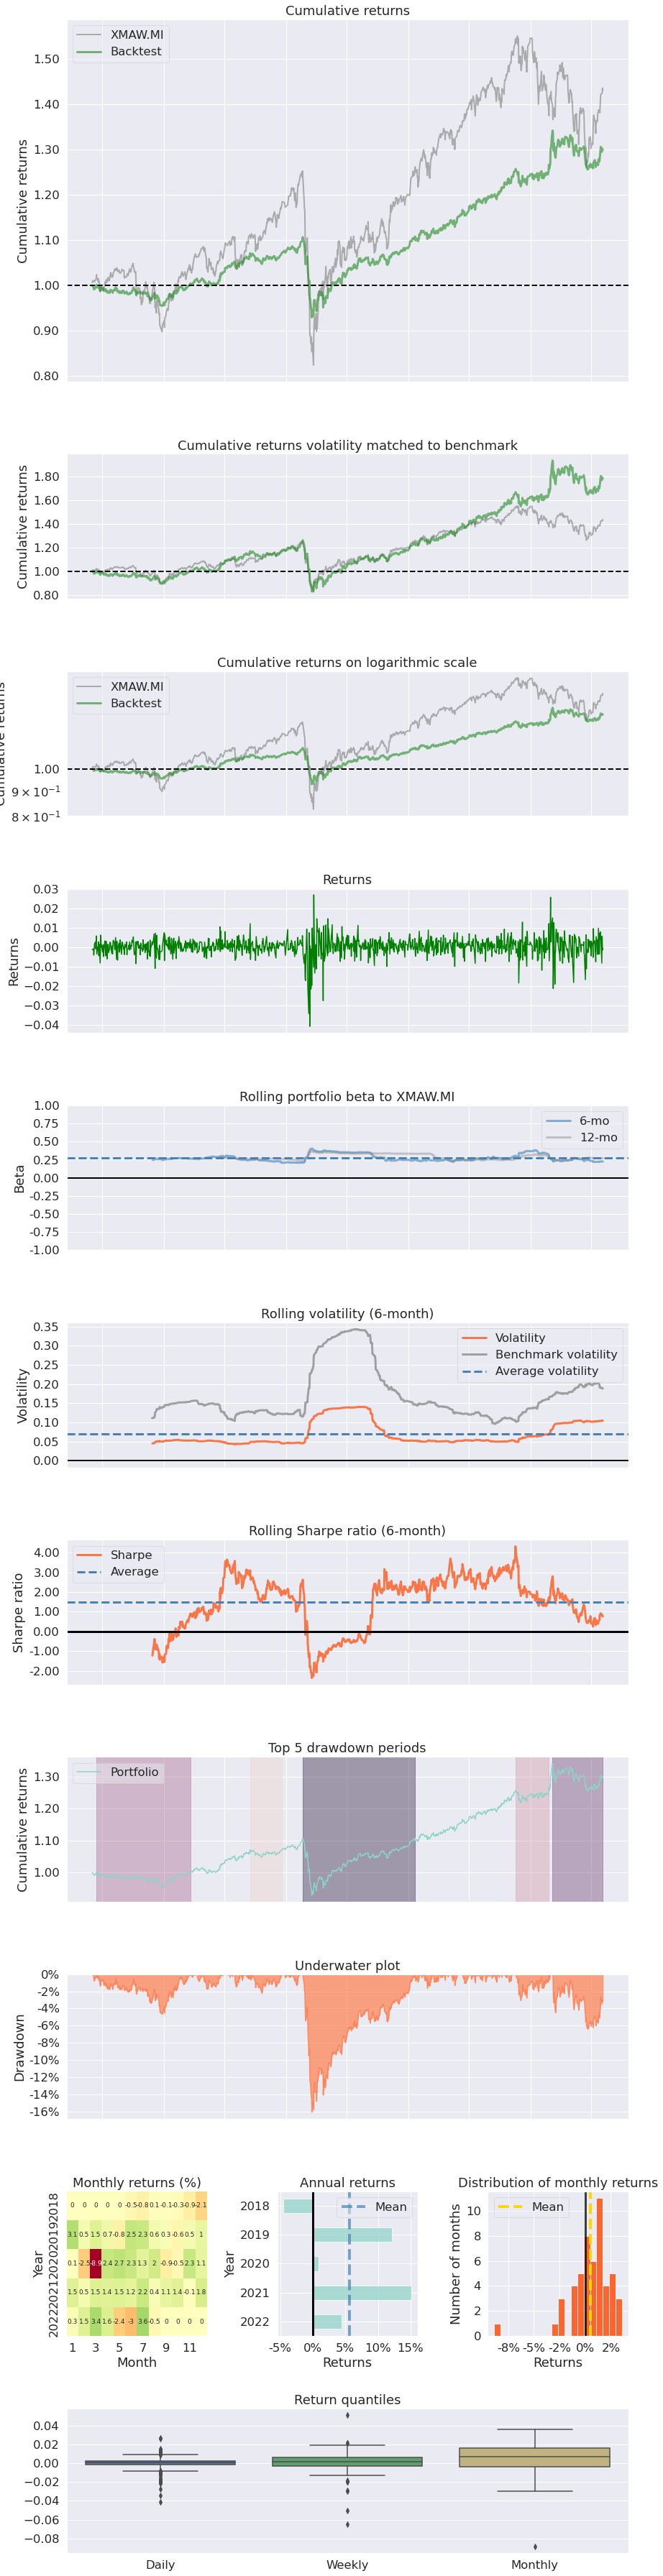

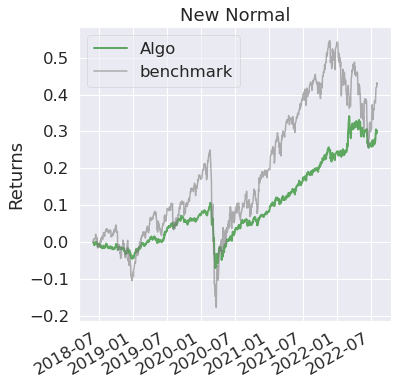

In [121]:
pyfolio.create_full_tear_sheet(hist.pct_change().dropna(),benchmark_rets=rets['XMAW.MI']/100)